<a href="https://colab.research.google.com/github/OrJaku/others/blob/master/Pandas_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Import liberies

In [0]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
import eli5
from eli5.sklearn import PermutationImportance


ModuleNotFoundError: ignored

In [0]:
!pip install xgboost

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Pandas'

/content/drive/My Drive/Colab Notebooks/Pandas


In [0]:
from google.colab import files
files.upload()


In [0]:
df = pd.read_csv('data/cars.csv')

In [0]:
print(df.shape)
df.columns

(387, 15)


Index(['Unnamed: 0', 'AWD', 'RWD', 'Retail', 'Dealer', 'Engine', 'Cylinders',
       'Horsepower', 'CityMPG', 'HighwayMPG', 'Weight', 'Wheelbase', 'Length',
       'Width', 'Class'],
      dtype='object')

In [0]:
df.head()

####Delete columns

In [0]:
df_filtered = df.copy()
# del df_filtered['Dealer']
del df_filtered['Wheelbase']

####Chnage columns name 

In [0]:
df_filtered  = df_filtered.rename(columns={'Retail': 'Price'})
df_filtered  = df_filtered.rename(columns={'Unnamed: 0': 'Name'})

df_filtered.head()

,Name,AWD,RWD,Price,Dealer,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Length,Width,Class
0,Acura 3.5 RL,0,0,43755,39014,3.5,6,225,18,24,3880,197,72,Sedan
1,Acura 3.5 RL Navigation,0,0,46100,41100,3.5,6,225,18,24,3893,197,72,Sedan
2,Acura MDX,1,0,36945,33337,3.5,6,265,17,23,4451,189,77,SUV
3,Acura NSX S,0,1,89765,79978,3.2,6,290,17,24,3153,174,71,Sports
4,Acura RSX,0,0,23820,21761,2.0,4,200,24,31,2778,172,68,Sedan


####Copy data to new data frames 

In [0]:
df_ext = df_filtered.copy()

In [0]:
df_ext.head()

,Name,AWD,RWD,Price,Engine,Cylinders,Horsepower,CityMPG,HighwayMPG,Weight,Length,Width,Class
0,Acura 3.5 RL,0,0,43755,3.5,6,225,18,24,3880,197,72,Sedan
1,Acura 3.5 RL Navigation,0,0,46100,3.5,6,225,18,24,3893,197,72,Sedan
2,Acura MDX,1,0,36945,3.5,6,265,17,23,4451,189,77,SUV
3,Acura NSX S,0,1,89765,3.2,6,290,17,24,3153,174,71,Sports
4,Acura RSX,0,0,23820,2.0,4,200,24,31,2778,172,68,Sedan


####Splite column Name to two new columns Brand and Model

In [0]:
brand = pd.Series([]) 
model = pd.Series([])

for i, feature in enumerate(df_filtered['Name']):
  brand[i] = feature.split(' ')[0]
  model[i] = feature.split(' ')[1]

try: 
  df_ext.insert(1, "Brand", brand) 
except ValueError:
  pass
try:
  df_ext.insert(2, "Model", model) 
except ValueError:
  pass

del df_ext["Name"]

In [0]:
 df_ext.sort_values("Price",ascending=False) 

In [0]:
df_ext['Price_around'] = pd.cut(x=df_ext['Price'], bins=[9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 150000, 200000], labels=["10000", "20000", "30000", "40000", "50000", "60000", "70000", "80000", "90000", "100000", "150000", "200000"])

In [0]:
df_ext.info()

####Mean, Median and Histogram

In [0]:
mean_price = int(np.mean(df_ext.Price))
median_price = int(np.median(df_ext.Price))
print("Mean {} || Median {}".format(mean_price, median_price))


Mean 33231 || Median 28495


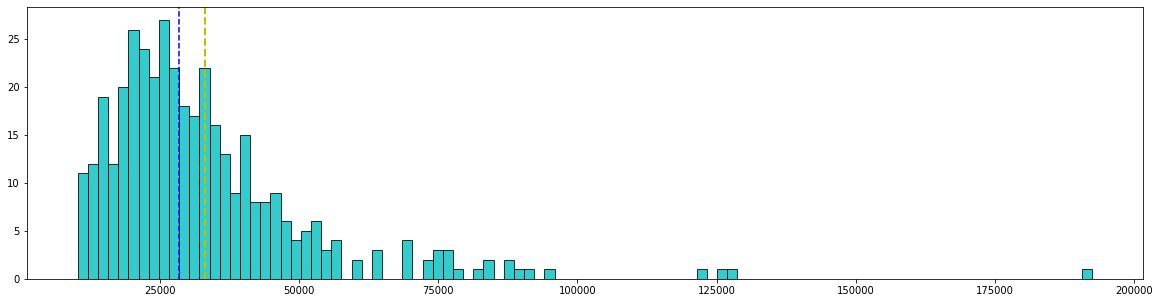

In [0]:
plt.figure(figsize=(20,5))
plt.hist(df_ext['Price'],bins=100,  color='c', edgecolor='k', alpha=0.8)
plt.axvline(mean_price, color='y', linestyle='dashed', linewidth=2)
plt.axvline(median_price, color='b', linestyle='dashed', linewidth=1.5)
# plt.axhline(10, color='r', linestyle='dashed', linewidth=.5)

In [0]:
y_true = df_ext["Price"]
y_pred = [mean_price] * y_true.shape[0]
mean_absolute_error(y_true, y_pred)

13231.28165374677

In [0]:
df_ext['Brand'].unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'GMC', 'Honda', 'Hummer', 'Hyundai',
       'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus',
       'Lincoln', 'Mazda6', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mini',
       'Mitsubishi', 'Nissan', 'Oldsmobile', 'Pontiac', 'Porsche', 'Saab',
       'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [0]:
df_ext['Brand_cat'] = df_ext['Brand'].map(lambda x: str(x.lower())).factorize()[0]
df_ext['Class_cat'] = df_ext['Class'].map(lambda x: str(x.lower())).factorize()[0]

####Show rows if columns  "Brand" is "BMW"

In [0]:
df_ext.loc[df_ext['Brand'] == "BMW"]

####Shows just choosen columns

In [0]:
df_ext[ ['Brand', 'Brand_cat'] ]

####Compere values in columns


In [0]:
df_ext[df_ext.Price != df_ext.Dealer].shape

####Run model - DecisionTreeRegressor

In [0]:
def run_model_1(feats, pred_model, max_depth=5, random_state=0):  
  X = df_ext[feats].values
  y = df_ext["Price"].values
  model = pred_model(max_depth=max_depth, random_state=random_state)
  score = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
  model.fit(X,y)
  print(np.mean(score))
  return  np.mean(score)
run_model_1(["Brand_cat", "Class_cat", "Horsepower"], DecisionTreeRegressor)


-7740.2624781381965


-7740.2624781381965

####Run model -  DecisionTreeRegressor to Predict


In [0]:
  X = df_ext[["Horsepower","Engine", "Cylinders", "AWD", "Brand_cat",  "Class_cat"]].values
  y = df_ext["Price"].values
  model = DecisionTreeRegressor(max_depth=5)
  model.fit(X,y)
  model.predict([[200, 4, 12, 0, 2,2]])

array([24859.08108108])

####Prediction DTR

In [0]:
def run_model_2(feats, pred_model, max_depth=5, n_estimators=100, random_state=0):  
  X = df_ext[feats].values
  y = df_ext["Price"].values
  model = pred_model(max_depth=max_depth, random_state=random_state)
  score = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
  model.fit(X,y)
  print(np.mean(score))
  return  np.mean(score)

run_model_2(["Brand_cat", "Class_cat", "Horsepower"], RandomForestRegressor, max_depth=5, n_estimators=100, random_state=0)


-7363.768933778825


-7363.768933778825

In [0]:
feats = ["Horsepower","Engine", "Cylinders", "AWD", "Brand_cat",  "Class_cat", 	"CityMPG",	"HighwayMPG"]
X = df_ext[feats].values
y = df_ext["Price"].values

model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0)
model.fit(X, y)

perm = PermutationImportance(model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names=feats)


Weight,Feature
1.6375 ± 0.1886,Horsepower
0.0475 ± 0.0134,HighwayMPG
0.0305 ± 0.0053,Engine
0.0304 ± 0.0040,Brand_cat
0.0206 ± 0.0040,CityMPG
0.0066 ± 0.0016,Class_cat
0.0060 ± 0.0025,Cylinders
0.0003 ± 0.0006,AWD


In [0]:
df_ext.Brand.value_counts(normalize=True).map(lambda x: x*100)